In [7]:
# %pip install torch pandas numpy sklearn matplotlib
from utils import *

import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import matplotlib.pyplot as plt


# Procesamiento

In [8]:
def datasensor(sensor:str, ruth:str = "/home/azureuser/cloudfiles/code/Users/jordanperez/Proyecto/Data_filtrada_VLTI/"):

    data_1 = pd.read_csv(ruth + sensor + "_2021-01_filtrado.csv", index_col=0)   
    data_2 = pd.read_csv(ruth + sensor + "_2021-02_filtrado.csv", index_col=0)
    data_3 = pd.read_csv(ruth + sensor + "_2021-03_filtrado.csv", index_col=0)
    data_4 = pd.read_csv(ruth + sensor + "_2021-04_filtrado.csv", index_col=0)
    data_5 = pd.read_csv(ruth + sensor + "_2021-05_filtrado.csv", index_col=0)
    data_6 = pd.read_csv(ruth + sensor + "_2021-06_filtrado.csv", index_col=0)
    data_7 = pd.read_csv(ruth + sensor + "_2021-07_filtrado.csv", index_col=0)
    data_8 = pd.read_csv(ruth + sensor + "_2021-08_filtrado.csv", index_col=0)
    data_9 = pd.read_csv(ruth + sensor + "_2021-09_filtrado.csv", index_col=0)
    data_10 = pd.read_csv(ruth + sensor + "_2021-10_filtrado.csv", index_col=0)
    data_11 = pd.read_csv(ruth + sensor + "_2021-11_filtrado.csv", index_col=0)
    data_12 = pd.read_csv(ruth + sensor + "_2021-12_filtrado.csv", index_col=0)
    data_13 = pd.read_csv(ruth + sensor + "_2022-01_filtrado.csv", index_col=0)
    data_14 = pd.read_csv(ruth + sensor + "_2022-02_filtrado.csv", index_col=0)
    data_15 = pd.read_csv(ruth + sensor + "_2022-03_filtrado.csv", index_col=0)
    data_16 = pd.read_csv(ruth + sensor + "_2022-04_filtrado.csv", index_col=0)
    data_17 = pd.read_csv(ruth + sensor + "_2022-05_filtrado.csv", index_col=0)
    data_18 = pd.read_csv(ruth + sensor + "_2022-06_filtrado.csv", index_col=0)

        # Lista con los DataFrames que deseas concatenar
    dataframes = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10, data_11, data_12, data_13, data_14, data_15, data_16, data_17, data_18]

    # Concatenar los DataFrames a lo largo del eje 0 (filas)
    concatenated_data = pd.concat(dataframes)
    #columnas_excluidas = ['guiding', 'presetting', 'enc_open', 'coude_focus', 'nasA_focus',
    #   'nasB_focus', 'cas_focus', 'bad_guiding', 'AS_update', 'PS_update']
       
    #concatenated_data = concatenated_data.drop(columnas_excluidas, axis=1)

    columnas = concatenated_data.columns.values.astype(float)

    filtro = columnas>10

    return concatenated_data.loc[:, filtro]

# m1-3

In [9]:
data_m13 = datasensor("m1-3_psds_UT2")

# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_m13, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [10]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [11]:
from torch import nn
import torch
import numpy as np

class Encoder(nn.Module):
    def __init__(self, n_features, n_embedding, drop_out=0.1):
        super(Encoder, self).__init__()

        self.linear_encoder_1 = nn.Linear(n_features, 512)
        self.linear_encoder_2 = nn.Linear(512, 256)
        self.linear_encoder_3 = nn.Linear(256, 128)
        self.linear_encoder_4 = nn.Linear(128, n_embedding)
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x):
        x = self.dropout(torch.relu(self.linear_encoder_1(x)))
        x = self.dropout(torch.relu(self.linear_encoder_2(x)))
        x = self.dropout(torch.relu(self.linear_encoder_3(x)))
        x = self.linear_encoder_4(x)
        return x



class Decoder(nn.Module):
    def __init__(self, n_embedding, n_features, dropout=0.1):
        super(Decoder, self).__init__()

        self.linear_decoder_1 = nn.Linear(n_embedding, 128)
        self.dropout_1 = nn.Dropout(dropout)
        self.linear_decoder_2 = nn.Linear(128, 256)
        self.dropout_2 = nn.Dropout(dropout)
        self.linear_decoder_3 = nn.Linear(256, 512)
        self.dropout_3 = nn.Dropout(dropout)
        self.linear_decoder_4 = nn.Linear(512, n_features)

    def forward(self, x):
        x = nn.ReLU()(self.linear_decoder_1(x))
        x = self.dropout_1(x)
        x = nn.ReLU()(self.linear_decoder_2(x))
        x = self.dropout_2(x)
        x = nn.ReLU()(self.linear_decoder_3(x))
        x = self.dropout_3(x)
        x = self.linear_decoder_4(x)
        return x


class VariationalAutoencoder(nn.Module):
    def __init__(self, n_features, n_embedding, dropout=0.1):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(n_features, n_embedding, dropout)
        self.decoder = Decoder(n_embedding, n_features, dropout)
        
        self.mean_layer = nn.Linear(n_embedding, n_embedding)
        self.logvar_layer = nn.Linear(n_embedding, n_embedding)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, x):
        encoded = self.encoder(x)
        mean = self.mean_layer(encoded)
        logvar = self.logvar_layer(encoded)
        z = self.reparameterize(mean, logvar)
        decoded = self.decoder(z)
        return decoded, mean, logvar


class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.val_loss_min:
            self.counter = 0
            self.val_loss_min = val_loss
            self.best_model = model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop


def train_model(
    model,
    train_dataset,
    val_dataset,
    max_epochs,
    batch_size,
    lr,
    optimizer,
    perdida,
    early_stopping,
    use_gpu=False
):
    # Curvas de loss
    curves = {
        "train_loss": [],
        "val_loss": [],
    }

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    for epoch in range(max_epochs):
        cumulative_train_loss = 0

        # Entrenamiento del modelo
        model.train()
        for i, x_batch in enumerate(train_loader):
            # Predicción
            x_reconstructed, mean, logvar = model(x_batch)
            
            # Calcular la pérdida L1 solo entre las reconstrucciones y los datos de entrada
            loss = perdida(x_reconstructed, x_batch)

            # Actualización de parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

        train_loss = cumulative_train_loss / len(train_loader)

        # Evaluación del modelo
        model.eval()
        with torch.no_grad():
            for i, x_val in enumerate(val_loader):
                # Predicción
                x_reconstructed_val, mean_val, logvar_val = model(x_val)
                
                # Calcular la pérdida L1 solo entre las reconstrucciones y los datos de entrada
                val_loss = perdida(x_reconstructed_val, x_val).item()


                
        print("")
        print(f" - Train loss: {train_loss:.5f}, Val loss: {val_loss:.5f}")
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        if early_stopping(val_loss, model):
            print("Early stopping triggered!")
            break
 
    print()
    model.cpu()
    return curves


def show_curves(curves):
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1
    ax.plot(epochs, curves['val_loss'], label='validation')
    ax.plot(epochs, curves['train_loss'], label='training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss evolution during training')
    ax.legend()
    plt.show()



In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping=EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )





 - Train loss: 8.09866, Val loss: 1.67863

 - Train loss: 1.64724, Val loss: 2.22471

 - Train loss: 1.42540, Val loss: 4.01086

 - Train loss: 1.31803, Val loss: 3.45472

 - Train loss: 1.34705, Val loss: 3.40698

 - Train loss: 1.12794, Val loss: 3.49373


KeyboardInterrupt: 

In [7]:
# def show_curves(curves):
#     fig, ax = plt.subplots(1, 1, figsize=(13, 5))
#     fig.set_facecolor('white')

#     epochs = np.arange(len(curves["val_loss"])) + 1
#     ax.plot(epochs, curves['val_loss'], label='validation')
#     ax.plot(epochs, curves['train_loss'], label='training')
#     ax.set_xlabel('Epoch')
#     ax.set_ylabel('Loss')
#     ax.set_title('Loss evolution during training')
#     ax.legend()
#     plt.show()

In [12]:
type(history)

dict

In [13]:
for key in history:
    history[key] = history[key][1:]

In [14]:
history

{'train_loss': [1.9905023059329472,
  1.636533110528379,
  1.4470919241776337,
  1.3694497395206142,
  1.272021929959993,
  1.2274285184370506,
  1.1874523533357155,
  1.1337720461793848,
  1.1071768741349917,
  1.1197790769306388,
  1.057060154708656,
  1.004261483211775,
  0.9771070464237316,
  0.9774595249343563,
  0.9607763330678682,
  0.9649863041735984,
  0.8923037503216718,
  0.9143895965975684,
  0.8797168594759863,
  0.8474705702549702,
  0.8267420836397119,
  0.8252817513169469,
  0.8094298187139872,
  0.8351535039979059,
  0.8142294110478582,
  0.8004499464421659,
  0.7890185697658642,
  0.8063816693989007,
  0.7815835862546354,
  0.7802078015095478,
  0.7629927284008747,
  0.7982449016055545,
  0.7609662510253288,
  0.7534712271110432,
  0.7679011120989516,
  0.7422545165629,
  0.7682855701124346,
  0.7524162901414407,
  0.7277074891167719,
  0.735634935868753,
  0.7518518083804363,
  0.7413941283483763,
  0.735894743655179,
  0.7271150141148954,
  0.7265846978973698,
  0.7

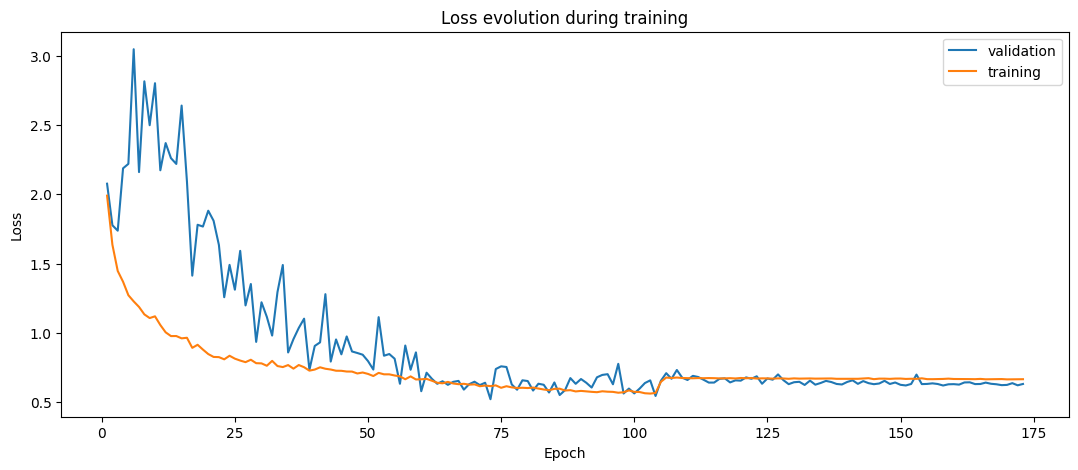

In [16]:
show_curves(history)

In [ ]:
modelo = early_stopping.best_model
torch.save(modelo, "./m1-3_VAE")

# m1

In [16]:
data_m1 = datasensor("m1_psds_UT2")

# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_m1, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [17]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )


 - Train loss: 8.65084, Val loss: 2.33481

 - Train loss: 1.73781, Val loss: 2.73084

 - Train loss: 1.50378, Val loss: 2.98926

 - Train loss: 1.35305, Val loss: 2.62510

 - Train loss: 1.30777, Val loss: 3.52106

 - Train loss: 1.23846, Val loss: 3.92950

 - Train loss: 1.17707, Val loss: 3.26438

 - Train loss: 1.14272, Val loss: 3.81831

 - Train loss: 1.16782, Val loss: 3.63562

 - Train loss: 1.05008, Val loss: 4.46065

 - Train loss: 1.15154, Val loss: 3.84082

 - Train loss: 1.01738, Val loss: 3.08883

 - Train loss: 1.01137, Val loss: 4.08439

 - Train loss: 0.96762, Val loss: 3.08656

 - Train loss: 0.99711, Val loss: 2.16241

 - Train loss: 1.00035, Val loss: 3.31673

 - Train loss: 0.92142, Val loss: 3.23285

 - Train loss: 0.92355, Val loss: 2.93306

 - Train loss: 0.97336, Val loss: 3.28428

 - Train loss: 0.91016, Val loss: 3.68341

 - Train loss: 0.88541, Val loss: 3.01599

 - Train loss: 0.88220, Val loss: 3.19100

 - Train loss: 0.86173, Val loss: 2.86532

 - Train l

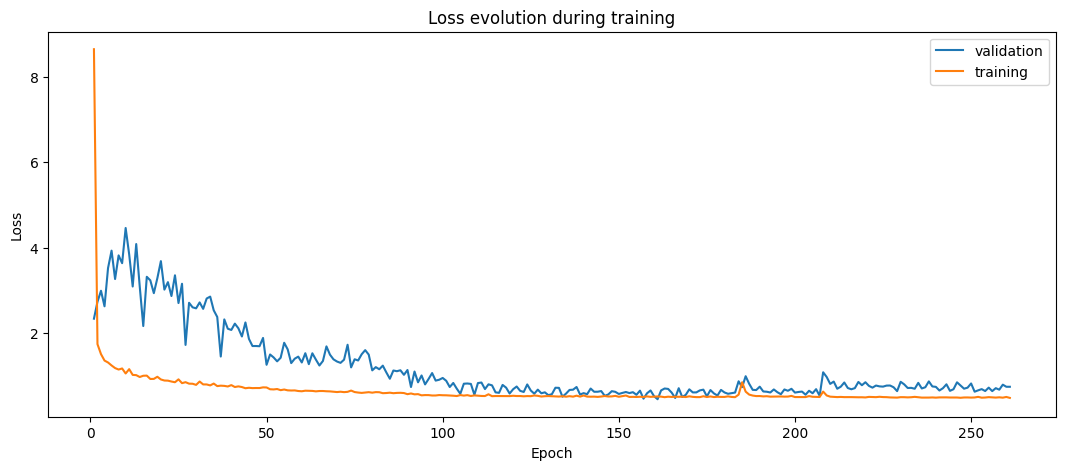

In [20]:
show_curves(history)


In [21]:
modelo = early_stopping.best_model
torch.save(modelo, "./m1_VAE")

# m2

In [22]:
data_m2 = datasensor("m2_psds_UT2")
# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_m2, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [23]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )


 - Train loss: 13.44596, Val loss: 1.87819

 - Train loss: 1.95951, Val loss: 2.33703

 - Train loss: 1.63150, Val loss: 2.62544

 - Train loss: 1.48755, Val loss: 2.94177

 - Train loss: 1.39110, Val loss: 2.83814

 - Train loss: 1.30324, Val loss: 2.88525

 - Train loss: 1.30233, Val loss: 3.12969

 - Train loss: 1.22103, Val loss: 3.25090

 - Train loss: 1.19218, Val loss: 2.70680

 - Train loss: 1.20768, Val loss: 3.52009

 - Train loss: 1.14562, Val loss: 3.23643

 - Train loss: 1.11107, Val loss: 2.49749

 - Train loss: 1.11937, Val loss: 2.85327

 - Train loss: 1.06309, Val loss: 2.75501

 - Train loss: 1.03653, Val loss: 2.48129

 - Train loss: 1.06865, Val loss: 1.87260

 - Train loss: 1.00867, Val loss: 1.68335

 - Train loss: 0.98859, Val loss: 2.70433

 - Train loss: 0.93424, Val loss: 2.04009

 - Train loss: 0.90292, Val loss: 2.39241

 - Train loss: 0.92171, Val loss: 2.08053

 - Train loss: 0.88547, Val loss: 1.59214

 - Train loss: 0.86283, Val loss: 1.76068

 - Train 

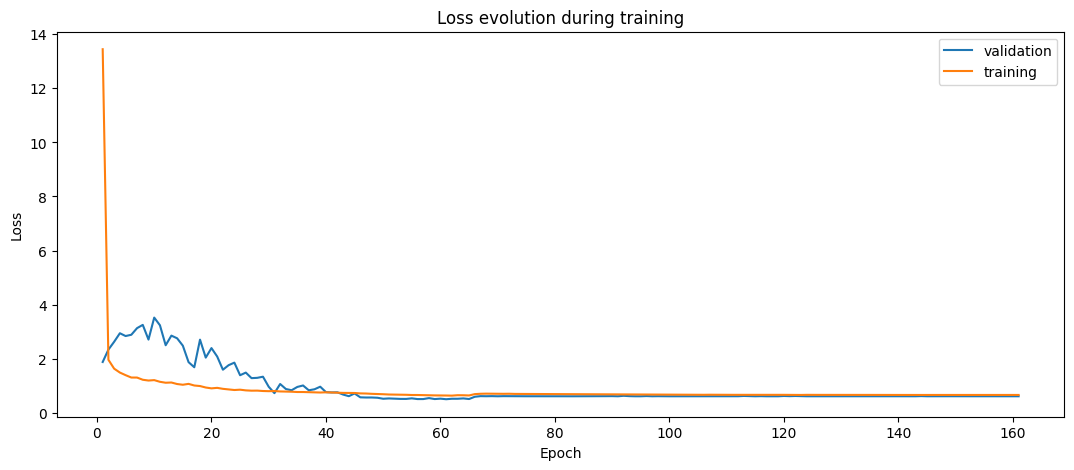

In [25]:
show_curves(history)
modelo = early_stopping.best_model
torch.save(modelo, "./m2_VAE")

# m3

In [26]:
data_m3 = datasensor("m3_psds_UT2")

# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_m3, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [27]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )



 - Train loss: 21.36987, Val loss: 2.67329

 - Train loss: 1.81783, Val loss: 2.95327

 - Train loss: 1.60334, Val loss: 3.51149

 - Train loss: 1.53363, Val loss: 2.50674

 - Train loss: 1.51110, Val loss: 3.10986

 - Train loss: 1.45103, Val loss: 3.15621

 - Train loss: 1.41875, Val loss: 3.84196

 - Train loss: 1.46489, Val loss: 2.88940

 - Train loss: 1.39259, Val loss: 3.00161

 - Train loss: 1.38804, Val loss: 2.77769

 - Train loss: 1.37852, Val loss: 3.23997

 - Train loss: 1.35965, Val loss: 3.57439

 - Train loss: 1.33660, Val loss: 3.54741

 - Train loss: 1.35980, Val loss: 3.68875

 - Train loss: 1.34160, Val loss: 3.41127

 - Train loss: 1.30868, Val loss: 3.55726

 - Train loss: 1.31979, Val loss: 3.28952

 - Train loss: 1.29228, Val loss: 3.51046

 - Train loss: 1.30548, Val loss: 3.67174

 - Train loss: 1.27271, Val loss: 3.38606

 - Train loss: 1.25365, Val loss: 3.10063

 - Train loss: 1.27034, Val loss: 3.25920

 - Train loss: 1.24791, Val loss: 3.15246

 - Train 

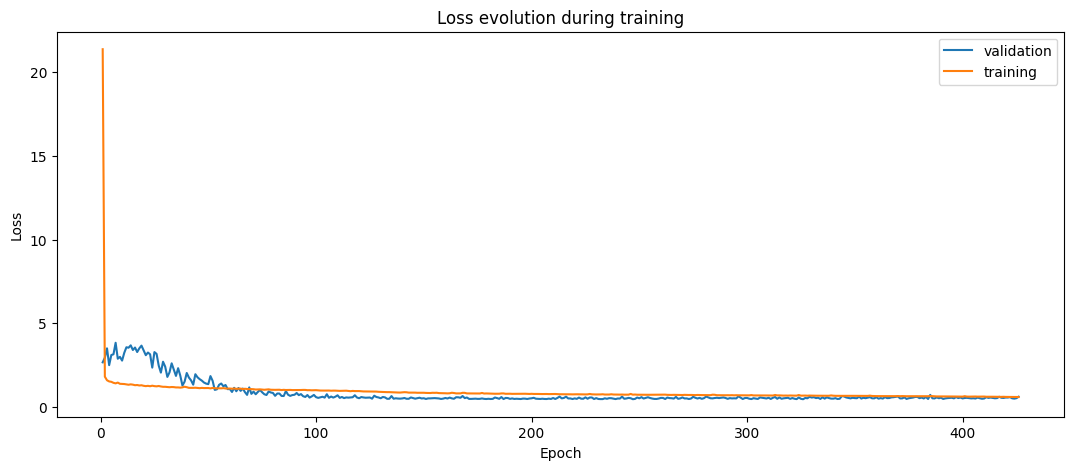

In [29]:
show_curves(history)
modelo = early_stopping.best_model
torch.save(modelo, "./m3_VAE")

# sensor 1

In [30]:
data_sensor_1 = datasensor("sensor_1_psds_UT2")
# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_sensor_1, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [31]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )



 - Train loss: 9.22719, Val loss: 1.01582

 - Train loss: 1.07006, Val loss: 1.51262

 - Train loss: 1.04523, Val loss: 1.41088

 - Train loss: 0.90236, Val loss: 1.39970

 - Train loss: 0.86534, Val loss: 1.81804

 - Train loss: 0.85560, Val loss: 1.68421

 - Train loss: 1.20490, Val loss: 2.83832

 - Train loss: 1.16059, Val loss: 1.69392

 - Train loss: 0.87394, Val loss: 1.45106

 - Train loss: 0.82713, Val loss: 1.65916

 - Train loss: 0.82540, Val loss: 1.85068

 - Train loss: 0.78616, Val loss: 2.04129

 - Train loss: 0.77444, Val loss: 1.88012

 - Train loss: 0.78330, Val loss: 1.89386

 - Train loss: 0.75355, Val loss: 1.77722

 - Train loss: 0.76050, Val loss: 1.93394

 - Train loss: 0.75107, Val loss: 1.90071

 - Train loss: 0.75653, Val loss: 2.23411

 - Train loss: 0.75615, Val loss: 2.10330

 - Train loss: 0.74420, Val loss: 2.18743

 - Train loss: 0.74146, Val loss: 1.78565

 - Train loss: 0.73401, Val loss: 1.98523

 - Train loss: 0.73521, Val loss: 2.00059

 - Train l

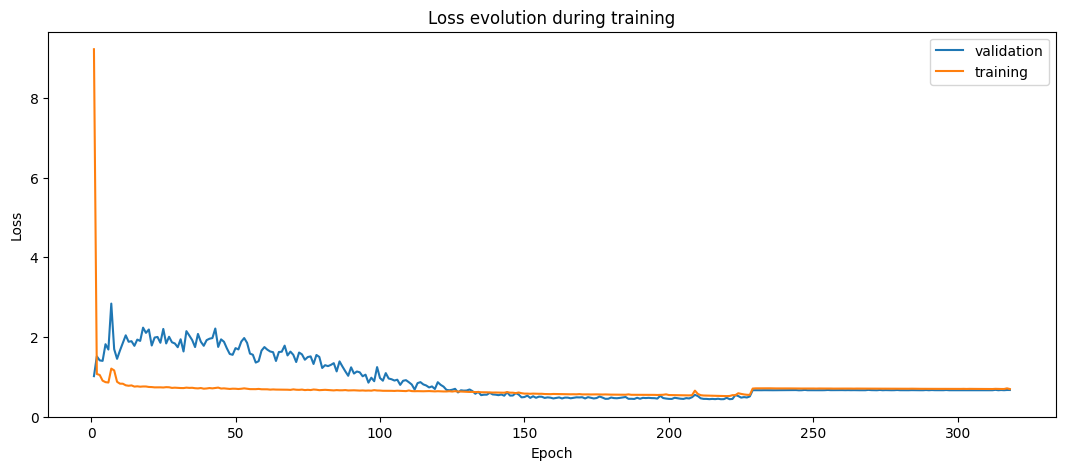

In [33]:
show_curves(history)
modelo = early_stopping.best_model
torch.save(modelo, "./sensor_1_VAE")

# sensor 2

In [62]:
data_sensor_2 = datasensor("sensor_2_psds_UT2")

# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_sensor_2, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [63]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )



 - Train loss: 10.83342, Val loss: 1.19234

 - Train loss: 1.20471, Val loss: 4.68443

 - Train loss: 8.17429, Val loss: 1.26544

 - Train loss: 1.02058, Val loss: 1.66918

 - Train loss: 0.95532, Val loss: 2.05935

 - Train loss: 0.90788, Val loss: 1.89799

 - Train loss: 0.86860, Val loss: 1.96166

 - Train loss: 0.84580, Val loss: 1.92333

 - Train loss: 0.82293, Val loss: 1.71001

 - Train loss: 0.81409, Val loss: 2.08803

 - Train loss: 0.79839, Val loss: 1.97856

 - Train loss: 0.78825, Val loss: 1.63495

 - Train loss: 0.78983, Val loss: 1.75334

 - Train loss: 0.76789, Val loss: 1.90122

 - Train loss: 0.75875, Val loss: 2.29704

 - Train loss: 0.75617, Val loss: 1.76614

 - Train loss: 0.75281, Val loss: 2.21624

 - Train loss: 0.74281, Val loss: 2.16361

 - Train loss: 0.73855, Val loss: 1.92050

 - Train loss: 0.73117, Val loss: 1.97577

 - Train loss: 0.73222, Val loss: 1.84589

 - Train loss: 0.72460, Val loss: 1.88361

 - Train loss: 0.73084, Val loss: 1.98236

 - Train 

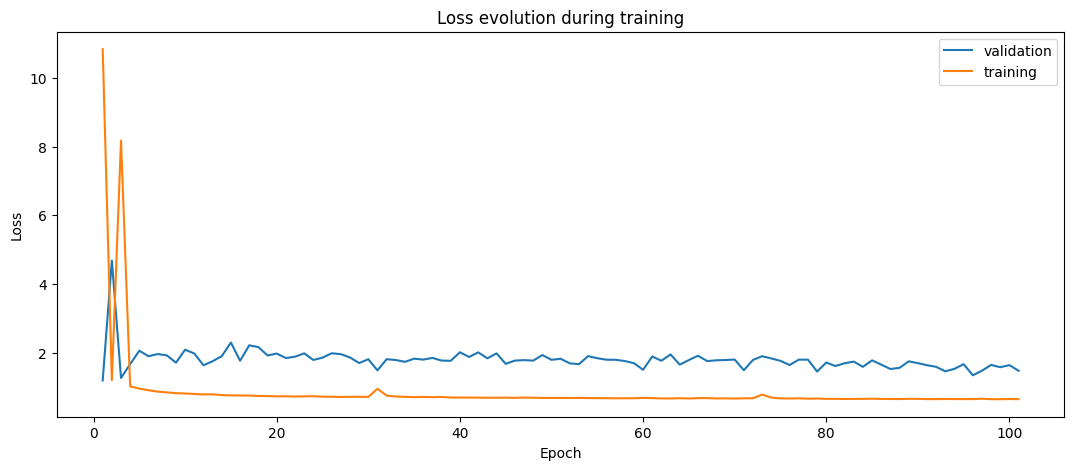

In [66]:
show_curves(history)
modelo = early_stopping.best_model
torch.save(modelo, "./sensor_2_VAE")

# sensor 3

In [67]:
data_sensor_3 = datasensor("sensor_3_psds_UT2")

# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_sensor_3, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [68]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )



 - Train loss: 10.63597, Val loss: 1.33734

 - Train loss: 1.18018, Val loss: 1.53862

 - Train loss: 1.04438, Val loss: 1.71807

 - Train loss: 1.01301, Val loss: 2.19581

 - Train loss: 0.95956, Val loss: 1.43578

 - Train loss: 0.95314, Val loss: 1.88689

 - Train loss: 0.95419, Val loss: 1.69777

 - Train loss: 0.90515, Val loss: 1.91281

 - Train loss: 0.90452, Val loss: 1.64681

 - Train loss: 0.90221, Val loss: 1.69143

 - Train loss: 0.88605, Val loss: 1.89503

 - Train loss: 0.87846, Val loss: 1.83316

 - Train loss: 0.89954, Val loss: 1.32820

 - Train loss: 0.86670, Val loss: 1.99493

 - Train loss: 0.85483, Val loss: 1.74356

 - Train loss: 0.84947, Val loss: 1.40545

 - Train loss: 0.83434, Val loss: 1.91928

 - Train loss: 0.83813, Val loss: 1.45297

 - Train loss: 0.82646, Val loss: 1.41571

 - Train loss: 0.83668, Val loss: 1.40043

 - Train loss: 0.82049, Val loss: 1.41236

 - Train loss: 0.81334, Val loss: 1.10602

 - Train loss: 0.80759, Val loss: 1.09542

 - Train 

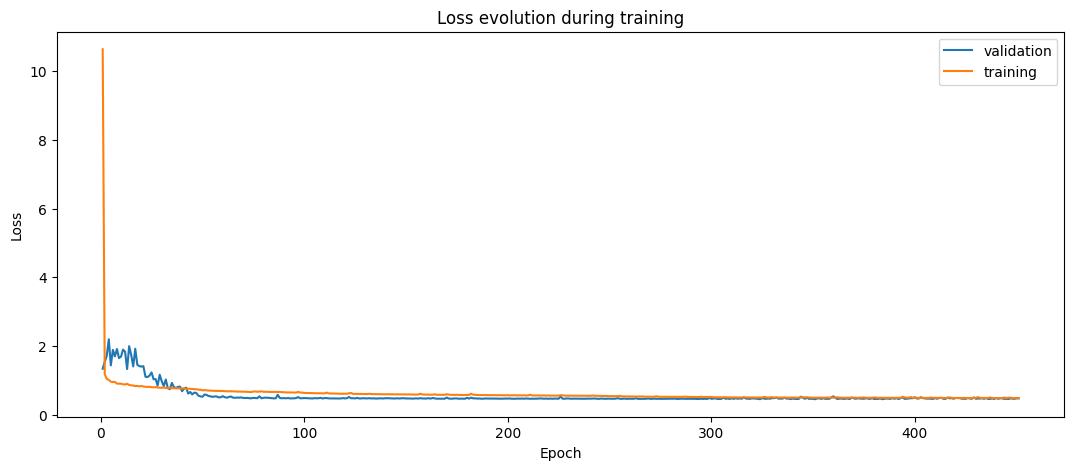

In [71]:
show_curves(history)
modelo = early_stopping.best_model
torch.save(modelo, "./sensor_3_VAE")

# sensor 4

In [42]:
data_sensor_4 = datasensor("sensor_4_psds_UT2")

# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_sensor_4, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [43]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )



 - Train loss: 8.47792, Val loss: 1.87002

 - Train loss: 1.52179, Val loss: 2.58752

 - Train loss: 1.31973, Val loss: 2.22407

 - Train loss: 1.18495, Val loss: 2.84226

 - Train loss: 1.09363, Val loss: 2.54305

 - Train loss: 1.04059, Val loss: 2.98313

 - Train loss: 1.00378, Val loss: 3.76473

 - Train loss: 1.05353, Val loss: 3.07784

 - Train loss: 0.91808, Val loss: 3.64570

 - Train loss: 0.89335, Val loss: 2.69924

 - Train loss: 0.86439, Val loss: 2.50565

 - Train loss: 0.88160, Val loss: 2.60103

 - Train loss: 0.77689, Val loss: 1.88674

 - Train loss: 0.77666, Val loss: 1.77390

 - Train loss: 0.74801, Val loss: 1.44325

 - Train loss: 0.72011, Val loss: 1.53592

 - Train loss: 0.68497, Val loss: 0.96324

 - Train loss: 0.70162, Val loss: 1.01798

 - Train loss: 0.65309, Val loss: 1.15995

 - Train loss: 0.61968, Val loss: 1.26565

 - Train loss: 0.62135, Val loss: 1.08346

 - Train loss: 0.60115, Val loss: 0.86832

 - Train loss: 0.59558, Val loss: 0.70385

 - Train l

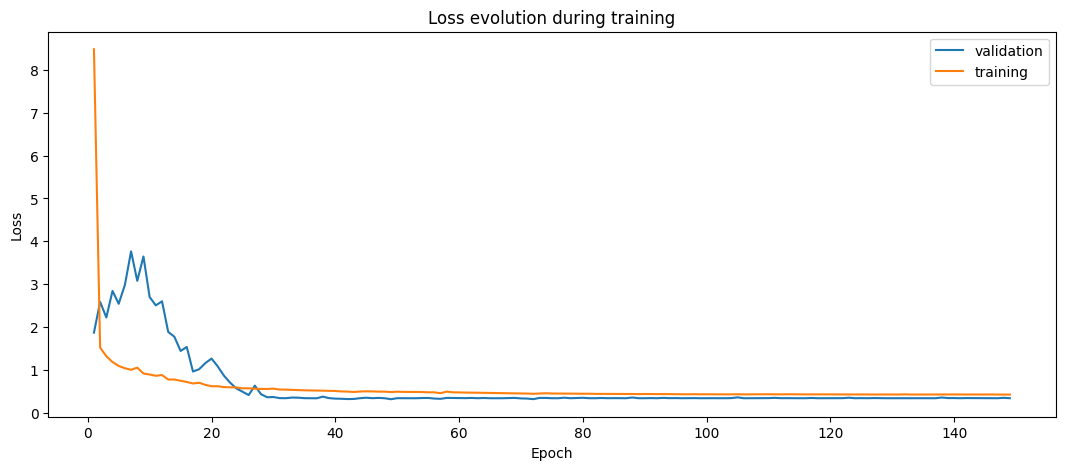

In [45]:
show_curves(history)
modelo = early_stopping.best_model
torch.save(modelo, "./sensor_4_VAE")

# sensor 5

In [84]:
data_sensor_5 = datasensor("sensor_5_psds_UT2")

# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_sensor_5, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [85]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )



 - Train loss: 6.66308, Val loss: 0.89925

 - Train loss: 1.68710, Val loss: 1.56636

 - Train loss: 1.05960, Val loss: 1.09118

 - Train loss: 0.94230, Val loss: 1.99703

 - Train loss: 0.93030, Val loss: 2.28107

 - Train loss: 0.87451, Val loss: 1.83186

 - Train loss: 0.86379, Val loss: 2.30709

 - Train loss: 0.83772, Val loss: 1.79076

 - Train loss: 0.82543, Val loss: 2.28778

 - Train loss: 0.79304, Val loss: 2.27274

 - Train loss: 0.77925, Val loss: 1.74051

 - Train loss: 0.81098, Val loss: 1.87548

 - Train loss: 0.75589, Val loss: 1.96812

 - Train loss: 0.79230, Val loss: 2.15246

 - Train loss: 0.77127, Val loss: 1.62261

 - Train loss: 0.73406, Val loss: 1.82934

 - Train loss: 0.73527, Val loss: 1.38079

 - Train loss: 0.71798, Val loss: 1.37793

 - Train loss: 0.73841, Val loss: 1.01454

 - Train loss: 0.73613, Val loss: 1.72312

 - Train loss: 0.75151, Val loss: 1.69573

 - Train loss: 0.70469, Val loss: 1.49901

 - Train loss: 0.69761, Val loss: 1.44361

 - Train l

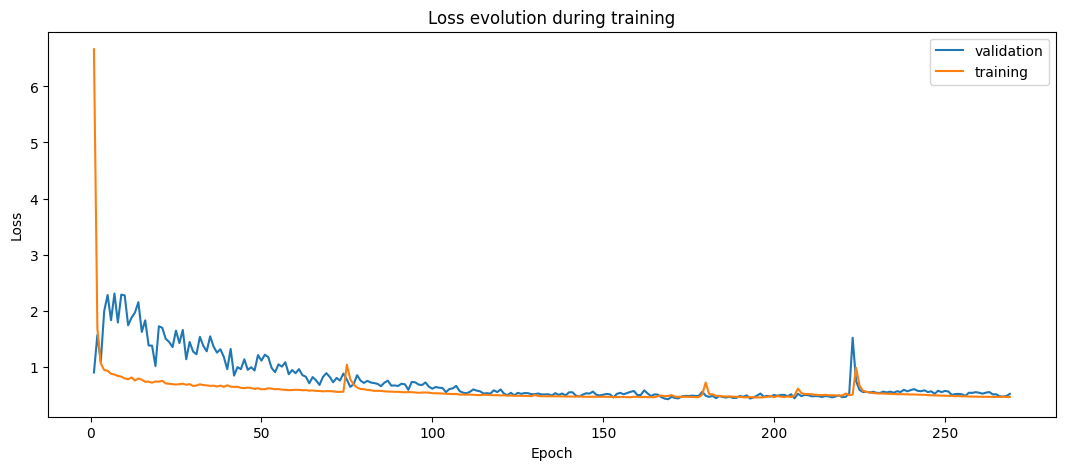

In [87]:
show_curves(history)
modelo = early_stopping.best_model
torch.save(modelo, "./sensor_5_VAE")

# sensor 6

In [88]:
data_sensor_6 = datasensor("sensor_6_psds_UT2")

# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_sensor_6, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [89]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )



 - Train loss: 8.01263, Val loss: 0.99112

 - Train loss: 1.40663, Val loss: 1.20335

 - Train loss: 1.96011, Val loss: 1.51484

 - Train loss: 1.08896, Val loss: 1.61414

 - Train loss: 1.01702, Val loss: 2.08718

 - Train loss: 0.97990, Val loss: 2.10109

 - Train loss: 0.96646, Val loss: 1.61808

 - Train loss: 0.93956, Val loss: 1.88404

 - Train loss: 0.92984, Val loss: 1.62267

 - Train loss: 0.92271, Val loss: 1.88841

 - Train loss: 0.91491, Val loss: 2.07886

 - Train loss: 0.90737, Val loss: 1.86387

 - Train loss: 0.89717, Val loss: 2.01238

 - Train loss: 0.87163, Val loss: 2.07702

 - Train loss: 0.86903, Val loss: 2.09980

 - Train loss: 0.86212, Val loss: 2.18211

 - Train loss: 0.87046, Val loss: 2.18330

 - Train loss: 0.85524, Val loss: 2.13583

 - Train loss: 0.84908, Val loss: 1.75498

 - Train loss: 0.85523, Val loss: 2.10218

 - Train loss: 0.82873, Val loss: 1.86047

 - Train loss: 0.82769, Val loss: 2.04864

 - Train loss: 0.83234, Val loss: 2.16771

 - Train l

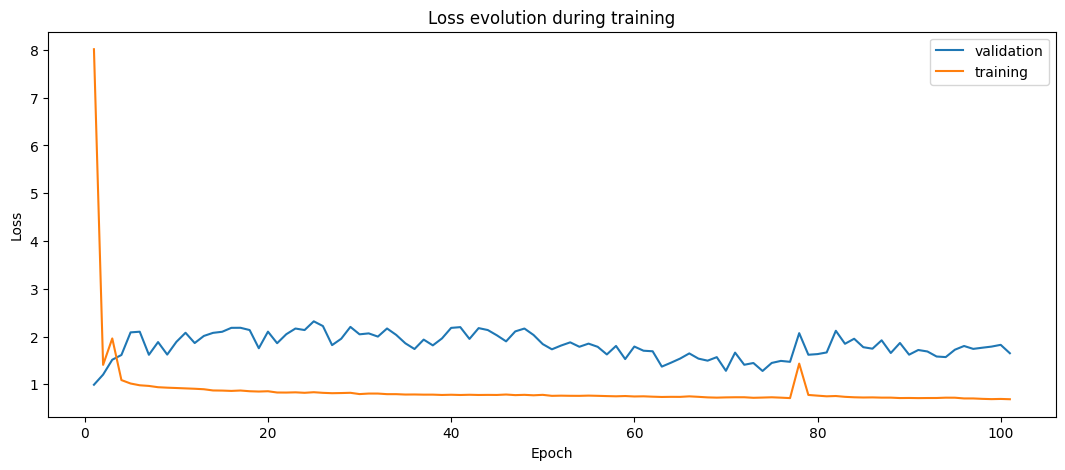

In [91]:
show_curves(history)
modelo = early_stopping.best_model
torch.save(modelo, "./sensor_6_VAE")

# sensor 7

In [99]:
data_sensor_7 = datasensor("sensor_7_psds_UT2")

# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_sensor_7, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [100]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )



 - Train loss: 4.60993, Val loss: 1.54625

 - Train loss: 1.10756, Val loss: 1.73232

 - Train loss: 0.99231, Val loss: 2.41454

 - Train loss: 8.81276, Val loss: 0.84247

 - Train loss: 1.18549, Val loss: 1.64023

 - Train loss: 0.98327, Val loss: 1.89482

 - Train loss: 0.88795, Val loss: 2.25561

 - Train loss: 0.84030, Val loss: 2.69774

 - Train loss: 0.81753, Val loss: 2.37247

 - Train loss: 0.78848, Val loss: 2.16777

 - Train loss: 0.77426, Val loss: 2.29808

 - Train loss: 0.75737, Val loss: 2.04051

 - Train loss: 0.75010, Val loss: 2.31468

 - Train loss: 0.74024, Val loss: 2.53276

 - Train loss: 0.73739, Val loss: 2.21192

 - Train loss: 0.72829, Val loss: 2.55604

 - Train loss: 0.71937, Val loss: 2.54778

 - Train loss: 0.70504, Val loss: 2.31932

 - Train loss: 0.69933, Val loss: 2.67903

 - Train loss: 0.73263, Val loss: 2.39622

 - Train loss: 0.69223, Val loss: 2.38596

 - Train loss: 0.70563, Val loss: 2.15569

 - Train loss: 0.68335, Val loss: 2.38980

 - Train l

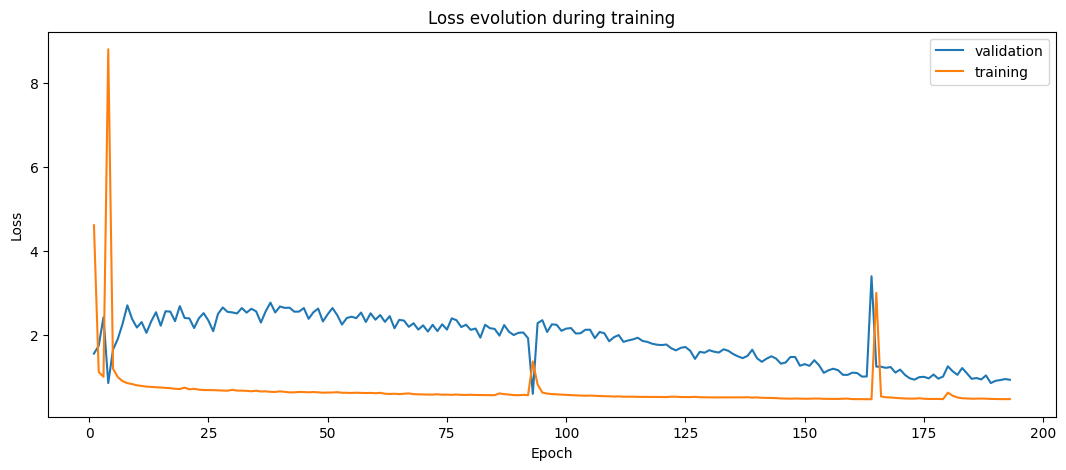

In [102]:
show_curves(history)
modelo = early_stopping.best_model
torch.save(modelo, "./sensor_7_VAE")

# sensor 8

In [58]:
data_sensor_8 = datasensor("sensor_8_psds_UT2")

# Dividir el DataFrame concatenado en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_sensor_8, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (37840, 1004)
Forma del conjunto de prueba: (9461, 1004)


In [59]:
train_tensor = torch.Tensor(np.log(train_data.dropna().values)).float()
val_tensor = torch.Tensor(np.log(test_data.dropna().values)).float()

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo= VariationalAutoencoder(1004, 100,0.08)

train = train_tensor
val = val_tensor

epocas = 1000
batch = 512
lr = 1e-3
optimizador = torch.optim.Adam(modelo.parameters())
perdida = nn.L1Loss()
# perdida = nn.MSELoss()

use_gpu = True
early_stopping = EarlyStopping(100)
history = train_model(modelo, train, val, epocas, batch, lr, optimizador, perdida, early_stopping, use_gpu )



 - Train loss: 4.34397, Val loss: 1.28070

 - Train loss: 1.05363, Val loss: 1.35371

 - Train loss: 0.97879, Val loss: 1.14714

 - Train loss: 1.02820, Val loss: 1.60549

 - Train loss: 0.83219, Val loss: 1.62282

 - Train loss: 0.83059, Val loss: 1.88483

 - Train loss: 0.98056, Val loss: 2.16716

 - Train loss: 0.92214, Val loss: 1.49521

 - Train loss: 0.79256, Val loss: 2.16397

 - Train loss: 0.74292, Val loss: 1.90339

 - Train loss: 0.73165, Val loss: 1.70182

 - Train loss: 0.72876, Val loss: 1.91924

 - Train loss: 0.72443, Val loss: 1.64449

 - Train loss: 0.70770, Val loss: 1.76697

 - Train loss: 0.68952, Val loss: 1.72544

 - Train loss: 0.67965, Val loss: 1.83807

 - Train loss: 0.68465, Val loss: 1.49553

 - Train loss: 0.67044, Val loss: 1.80352

 - Train loss: 0.69607, Val loss: 1.52727

 - Train loss: 0.65453, Val loss: 1.35522

 - Train loss: 0.65106, Val loss: 1.32074

 - Train loss: 0.65009, Val loss: 1.15247

 - Train loss: 0.60197, Val loss: 0.87642

 - Train l

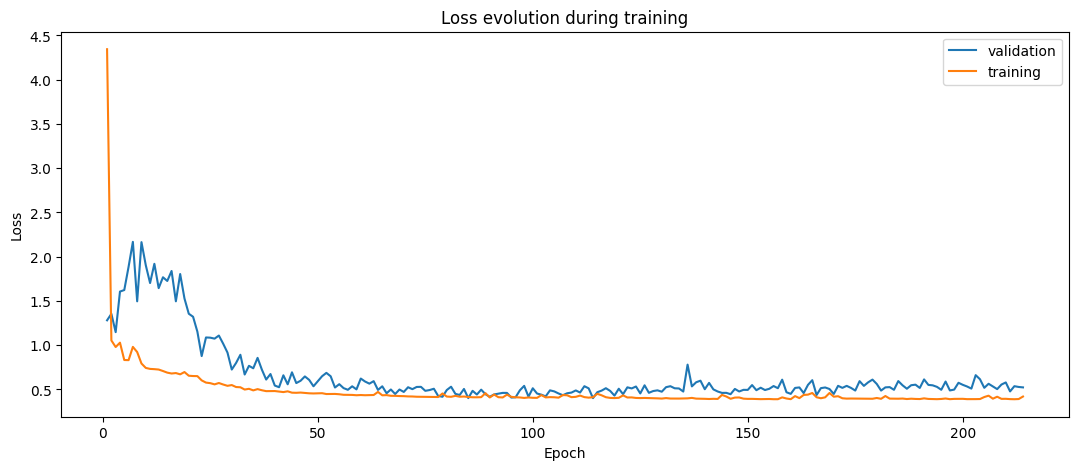

In [61]:
show_curves(history)
modelo = early_stopping.best_model
torch.save(modelo, "./sensor_8_VAE")
